In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading and PreProcessing of the dataset**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/dataset.csv")
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,2,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85704,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85705,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85706,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85707,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = data.iloc[:,1:]
y = data.label
del data

In [ ]:
y.value_counts()

11    22164
12    21387
1      4684
7      4401
3      4351
9      4188
2      4177
6      4137
0      4132
4      4072
8      4063
5      3795
13       80
10       78
Name: label, dtype: int64

In [ ]:
X = X/255.0 #grayscale normalization

In [ ]:
X = X.values.reshape(-1,28,28,1)
X.shape

(85709, 28, 28, 1)

In [ ]:
y = to_categorical(y, num_classes = 14)
y.shape

(85709, 14)

In [ ]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
randomSeed = 2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state = randomSeed)

**Building CNN model using keras**

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Dropout,MaxPool2D,Flatten
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
model = Sequential()

In [ ]:
#layer1
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

In [ ]:
#layer2
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

In [ ]:
#prediction layer
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(14, activation = "softmax"))

In [ ]:
opt = RMSprop(learning_rate = 0.001, rho = 0.9, epsilon = 1e-08, decay=0.0 )
model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])
#callback
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy",
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.0001)

In [ ]:
#data augmentation
augmentation = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
augmentation.fit(X_train)

In [ ]:
#preparing the hyperparameters
epoch = 5
mini_batch = 86

In [ ]:
#trainig the model
history = model.fit_generator(
                                augmentation.flow(X_train,y_train, batch_size=mini_batch),
                                epochs = epoch, #An epoch is an iteration over the entire x and y data provided
                                validation_data = (X_test,y_test), #Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                                verbose = 1, #output
                                steps_per_epoch=X_train.shape[0] // mini_batch,  # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
                                callbacks=[learning_rate_reduction]                            
                              )


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


896/896 [==============================] - 38s 29ms/step - loss: 0.2709 - accuracy: 0.9173 - val_loss: 0.0620 - val_accuracy: 0.9818 - lr: 0.0010
Epoch 2/5
896/896 [==============================] - 27s 30ms/step - loss: 0.0782 - accuracy: 0.9768 - val_loss: 0.0323 - val_accuracy: 0.9901 - lr: 0.0010
Epoch 3/5
896/896 [==============================] - 25s 28ms/step - loss: 0.0609 - accuracy: 0.9823 - val_loss: 0.0278 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 4/5
896/896 [==============================] - 23s 26ms/step - loss: 0.0547 - accuracy: 0.9845 - val_loss: 0.0255 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 5/5
896/896 [==============================] - 27s 30ms/step - loss: 0.0549 - accuracy: 0.9847 - val_loss: 0.0382 - val_accuracy: 0.9897 - lr: 0.0010


In [ ]:
#saving the model for use
model.save("kessu.h5")  

In [ ]:
#Prediction

from PIL import Image
from itertools import groupby

'loading image in grayscale'
image = Image.open("/content/7a472b75-e4d2-48bc-9a9b-7154c7f8a851.jpg").convert("L")

w = image.size[0]
h = image.size[1]
ratio = w/h
new_w = int(ratio*28)
new_h = 28
new_image = image.resize((new_w,new_h))
new_image_arr = np.array(new_image)
new_inv_image_arr = 255 - new_image_arr
final_image_arr = new_inv_image_arr/255.0
m = final_image_arr.any(0)
out = [final_image_arr[:,[*g]] for k, g in groupby(np.arange(len(m)), lambda x: m[x] != 0) if k]
num_of_elements = len(out)
elements_list = []
print(num_of_elements)
for x in range(0, num_of_elements):
    img = out[x]
    print(img.shape)
    #adding 0 value columns as fillers
    width = img.shape[1]
      filler = (final_image_arr.shape[0] - width) / 2
      
      if filler.is_integer() == False:    #odd number of filler columns
          filler_l = int(filler)
          filler_r = int(filler) + 1
      else:                               #even number of filler columns
          filler_l = int(filler)
          filler_r = int(filler)
      
      arr_l = np.zeros((final_image_arr.shape[0], filler_l)) #left fillers
      arr_r = np.zeros((final_image_arr.shape[0], filler_r)) #right fillers
      
      #concatinating the left and right fillers
      help_ = np.concatenate((arr_l, img), axis= 1)
      element_arr = np.concatenate((help_, arr_r), axis= 1)
      
      element_arr.resize(28, 28, 1) #resize array 2d to 3d
    #storing all elements in a list
    elements_list.append(element_arr)
elements_array = np.array(elements_list)
'reshaping to fit model input criteria'
elements_array = elements_array.reshape(-1, 28, 28, 1)
'predicting using the created model'
model = keras.models.load_model("/content/drive/MyDrive/Models/kessu.h5")
elements_pred =  model.predict(elements_array)
elements_pred = np.argmax(elements_pred, axis = 1)

In [ ]:
elements_pred

array([11,  2, 11,  9,  4,  1])

In [ ]:


def math_expression_generator(arr):
    
    op = {
              10,   # = "/"
              11,   # = "+"
              12,   # = "-"
              13    # = "*"
                  }   
    
    m_exp = []
    temp = []
        
    'creating a list separating all elements'
    for item in arr:
        if item not in op:
            temp.append(item)
        else:
            m_exp.append(temp)
            m_exp.append(item)
            temp = []
    if temp:
        m_exp.append(temp)
        
    'converting the elements to numbers and operators'
    i = 0
    num = 0
    for item in m_exp:
        if type(item) == list:
            if not item:
                m_exp[i] = ""
                i = i + 1
            else:
                num_len = len(item)
                for digit in item:
                    num_len = num_len - 1
                    num = num + ((10 ** num_len) * digit)
                m_exp[i] = str(num)
                num = 0
                i = i + 1
        else:
            m_exp[i] = str(item)
            m_exp[i] = m_exp[i].replace("10","/")
            m_exp[i] = m_exp[i].replace("11","+")
            m_exp[i] = m_exp[i].replace("12","-")
            m_exp[i] = m_exp[i].replace("13","*")
            
            i = i + 1
    
    
    'joining the list of strings to create the mathematical expression'
    separator = ' '
    m_exp_str = separator.join(m_exp)
    
    return (m_exp_str)

'creating the mathematical expression'
m_exp_str = math_expression_generator(elements_pred)

'calculating the mathematical expression using eval()'
while True:
    try:
        answer = eval(m_exp_str)    #evaluating the answer
        answer = round(answer, 2)
        equation  = m_exp_str + " = " + str(answer)
        print(equation)   #printing the equation
        break

    except SyntaxError:
        print("Invalid predicted expression!!")
        print("Following is the predicted expression:")
        print(m_exp_str)
        break

79 + 31 - 12 / 3 * 2 = 102.0


In [ ]:
print(new_inv_image_arr)

[[67 67 67 ... 61 63 64]
 [67 67 67 ... 59 60 63]
 [67 68 69 ... 59 58 60]
 ...
 [72 71 71 ... 81 80 81]
 [70 71 71 ... 82 82 82]
 [71 71 71 ... 82 83 82]]


In [ ]:
print(new_image_arr)

[[188 188 188 ... 194 192 191]
 [188 188 188 ... 196 195 192]
 [188 187 186 ... 196 197 195]
 ...
 [183 184 184 ... 174 175 174]
 [185 184 184 ... 173 173 173]
 [184 184 184 ... 173 172 173]]


In [ ]:
#Prediction

from PIL import Image
from itertools import groupby

'loading image in grayscale'
image = Image.open("/content/drive/MyDrive/Datasets/Testing Photos/matrix1.jpg").convert("L")
new_image_arr = np.array(image)
new_inv_image_arr = 255 - new_image_arr
#final_image_arr = new_inv_image_arr/255.0
n = new_inv_image_arr.any(1)
rows = [new_inv_image_arr[[*g],:] for k, g in groupby(np.arange(len(n)), lambda x: n[x] != 0) if k]

In [ ]:
Image.fromarray(new_inv_image_arr).size

(462, 332)

In [ ]:
new_inv_image_arr.shape

(332, 462)

In [ ]:
new_inv_image_arr.any(1)

array([False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
for k, g in groupby(np.arange(len(n)), lambda x: n[x] == True):
  print(k,*g)

False 0 1 2 3 4 5 6 7
True 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103
False 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
True 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
False 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
True 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 2

In [ ]:
Image.fromarray(rows[0]).size

(462, 96)

In [ ]:
image = Image.open("/content/drive/MyDrive/Datasets/Testing Photos/matrix1.jpg").convert("L")
new_image_arr = np.array(image)
new_inv_image_arr = 255 - new_image_arr
#final_image_arr = new_inv_image_arr/255.0
n = new_inv_image_arr.any(1)
rows = [new_inv_image_arr[[*g],:] for k, g in groupby(np.arange(len(n)), lambda x: n[x] != 0) if k]
r1 = Image.fromarray(rows[0])
r1 = r1.save('r1.png')

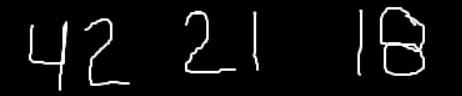

6
(28, 13)
(28, 16)
(28, 16)
(28, 5)
(28, 5)
(28, 15)


In [ ]:
#Prediction

from PIL import Image
from itertools import groupby
image = Image.open("/content/r1.png").convert('L')
display(image)
w = image.size[0]
h = image.size[1]
ratio = w/h
new_w = int(ratio*28)
new_h = 28
new_image = image.resize((new_w,new_h))
new_image_arr = np.array(new_image)
final_image_arr = new_image_arr/255.0
m = final_image_arr.any(0)
out = [final_image_arr[:,[*g]] for k, g in groupby(np.arange(len(m)), lambda x: m[x] != 0) if k]
num_of_elements = len(out)
elements_list = []
print(num_of_elements)
for x in range(0, num_of_elements):
    img = out[x]
    print(img.shape)
    #adding 0 value columns as fillers
    width = img.shape[1]
    filler = (final_image_arr.shape[0] - width) / 2
    
    if filler.is_integer() == False:    #odd number of filler columns
        filler_l = int(filler)
        filler_r = int(filler) + 1
    else:                               #even number of filler columns
        filler_l = int(filler)
        filler_r = int(filler)
    
    arr_l = np.zeros((final_image_arr.shape[0], filler_l)) #left fillers
    arr_r = np.zeros((final_image_arr.shape[0], filler_r)) #right fillers
    
    #concatinating the left and right fillers
    help_ = np.concatenate((arr_l, img), axis= 1)
    element_arr = np.concatenate((help_, arr_r), axis= 1)
    
    element_arr.resize(28, 28, 1) #resize array 2d to 3d
    #storing all elements in a list
    elements_list.append(element_arr)
elements_array = np.array(elements_list)
'reshaping to fit model input criteria'
elements_array = elements_array.reshape(-1, 28, 28, 1)
'predicting using the created model'
model = keras.models.load_model("/content/drive/MyDrive/Models/kessu.h5")
elements_pred =  model.predict(elements_array)
elements_pred = np.argmax(elements_pred, axis = 1)

In [ ]:
flagf = 0
flagt = 0
for i in m:
  if(i == False):
    flagf+=1
    if(flagt!=0):
      print("flag true ", flagt)
      flagt=0
  elif(i == True):
    flagt+=1
    if(flagf!=0):
      print("flag false ", flagf)
      flagf=0

flag false  8
flag true  13
flag false  2
flag true  16
flag false  14
flag true  16
flag false  3
flag true  5
flag false  25
flag true  5
flag false  2
flag true  15


In [ ]:
elements_pred

array([4, 2, 2, 1, 1, 8])

In [ ]:
def matrix(path):
  from PIL import Image
  from itertools import groupby
  'loading image in grayscale'
  image = Image.open(path).convert("L")
  new_image_arr = np.array(image)
  new_inv_image_arr = 255 - new_image_arr
  #final_image_arr = new_inv_image_arr/255.0
  n = new_inv_image_arr.any(1)
  rows = [new_inv_image_arr[[*g],:] for k, g in groupby(np.arange(len(n)), lambda x: n[x] != 0) if k]
  whole_matrix
  for i